# US Crime Communities 
### EDA & Hypothesis Testing

This is a dataset of 2018 US communities, demographics of each community, and their crime rates. The dataset has 146 variables where the first four columns are community/location, the middle features are demographic information about each community such as population, age, race, income, and the final columns are types of crimes and overall crime rates.

Table of Contents

Read in the data

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

Populating the interactive namespace from numpy and matplotlib


### Data Understanding

In [2]:
data = pd.read_csv('crimedata.csv')

In [3]:
data.head(3)

,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51


In [4]:
data.shape

(2215, 146)

Since we have 146 columns, we can perform a process of removing columns by inspection of quality and suitability for the analysis.

### Missing Values

In [5]:
missing_vols = pd.DataFrame(data.isnull().sum().sort_values(ascending=False))
missing_vols.reset_index(inplace=True)

In [6]:
missing_vols.head()

,index,0
0,PctPolicBlack,1872
1,PolicAveOTWorked,1872
2,PolicOperBudg,1872
3,LemasPctPolicOnPatr,1872
4,LemasGangUnitDeploy,1872


In [7]:
missing_vols.rename(columns={'index':'feature', 0:'total_missing'}, inplace=True)

In [8]:
missing_vols.describe()

,total_missing
count,146.000000
mean,305.424658
std,677.865329
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,1872.000000


In [9]:
# drop columns with 1872 missing
pd.set_option("display.max_columns", 200)
drop_list = missing_vols[missing_vols['total_missing'] == 1872]['feature'].unique().tolist()
data.drop([i for i in drop_list], axis=1, inplace=True)
data.shape

(2215, 124)

In [18]:

# inspect others above mean
mean_missing = missing_vols['total_missing'].mean()
missing_vols[(missing_vols.total_missing > mean_missing) & (missing_vols.total_missing != 1872)]
data.drop(columns=["communityCode", "countyCode"],inplace=True)

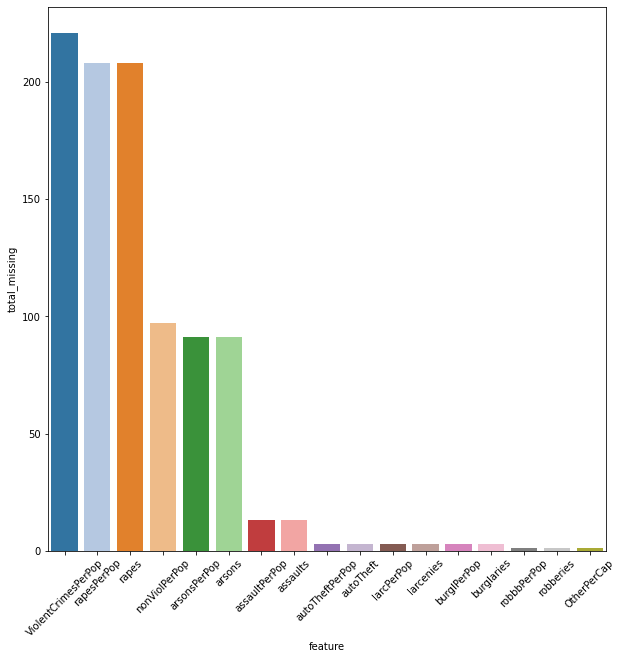

In [39]:
missing_vols = pd.DataFrame(data.isnull().sum().sort_values(ascending=False))
missing_vols.reset_index(inplace=True)
missing_vols.rename(columns={'index':'feature', 0:'total_missing'}, inplace=True)

# Visualise the missing data volumes for the remaining columns
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.barplot(data=missing_vols[missing_vols['total_missing'] != 0],
                    x='feature', y="total_missing", ax=ax, palette='tab20')
plot.set_xticklabels(labels=plot.get_xticklabels(),rotation=45)
plt.show()

We have some remaining null values in the crime type columns. However before we decide on the most appropriate treatment, for them, we will drop the crime detail columns that have just the total number. For this analysis, it is more useful to utilise the columns that have the crime detail "Per Population" (per 100K of the town's overall population). This will be more useful when we begin to compare attributes.

In [47]:
pd.set_option("display.max_seq_items", 500)
data.columns[::-1]

Index(['nonViolPerPop', 'ViolentCrimesPerPop', 'arsonsPerPop', 'arsons',
       'autoTheftPerPop', 'autoTheft', 'larcPerPop', 'larcenies',
       'burglPerPop', 'burglaries', 'assaultPerPop', 'assaults', 'robbbPerPop',
       'robberies', 'rapesPerPop', 'rapes', 'murdPerPop', 'murders',
       'LemasPctOfficDrugUn', 'PctUsePubTrans', 'PopDens', 'LandArea',
       'PctSameState85', 'PctSameCity85', 'PctSameHouse85', 'PctBornSameState',
       'PctForeignBorn', 'NumStreet', 'NumInShelters', 'MedOwnCostPctIncNoMtg',
       'MedOwnCostPctInc', 'MedRentPctHousInc', 'MedRent', 'RentQrange',
       'RentHighQ', 'RentMedian', 'RentLowQ', 'OwnOccQrange', 'OwnOccHiQuart',
       'OwnOccMedVal', 'OwnOccLowQuart', 'PctWOFullPlumb', 'PctHousNoPhone',
       'MedYrHousBuilt', 'PctVacMore6Mos', 'PctVacantBoarded', 'PctHousOwnOcc',
       'PctHousOccup', 'HousVacant', 'MedNumBR', 'PctHousLess3BR',
       'PctPersDenseHous', 'PctPersOwnOccup', 'PersPerRentOccHous',
       'PersPerOwnOccHous', 'PersPerO

We can also see that there are specific attributes of the city, such as the number of people born in the same state, that are not going to be included in this analysis. These columns will also be dropped.

In [64]:
cols_to_drop = ['arsons','autoTheft','larcenies','burgalries','assaults','robberies','rapes','murders',
                'PctBornSameState','PctSameHouse85','PctNotSpeakEnglWell', 'PctSpeakEnglOnly','FemalePctDiv',
                'MalePctDivorce','PctRecImmig10','PctRecImmig8','PctRecentImmig','PctImmigRec10','PctImmigRec8',
                'PctImmigRecent','NumKidsBornNeverMar','PctTeen2Par','PctYoungKids2Par','PctKids2Par',
                'PctWorkMomYoungKids',' MedNumBR','HousVacant','PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt'
                'PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal','OwnOccHiQuart','RentLowQ',
                'RentMedian','RentHighQ','MedRent','MedOwnCostPctInc','MedOwnCostPctIncNoMtg','LemasSwornFT',
                'LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasSwFTFieldPerPop','NumKindsDrugsSeiz',
                'PolicCars','LemasGangUnitDeploy','OfficAssgnDrugUnits','numbUrban', 'pctWWage', 'pctWFarmSelf',
                'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'NumUnderPov', 'PctLess9thGrade',
                'PctEmplManu', 'PctOccupManu', 'PctEmplProfServ','OtherPerCap']
len(cols_to_drop)
#data.drop

63

Target categories for the analysis:
* Police presence in the community
* Homelessness rates
* Household income
* Level of Education
* Family unit structure
* Race prevalence
* Proportion of immigrants
* Employment/Unemployment

In [65]:
current_cols = data.columns.tolist()

for col in cols_to_drop:
    if col in current_cols:
        data.drop(columns=col, inplace=True)

In [66]:
data.shape

(2215, 62)

In [57]:
pd.set_option("display.max_seq_items", 100)
data.columns

Index(['communityName', 'state', 'population', 'householdsize', 'racepctblack',
       'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21',
       'agePct12t29', 'agePct16t24', 'agePct65up', 'pctUrban', 'medIncome',
       'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap',
       'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov',
       'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy',
       'PctOccupMgmtProf', 'MalePctNevMarr', 'TotalPctDiv', 'PersPerFam',
       'PctFam2Par', 'PctWorkMom', 'PctKidsBornNeverMar', 'NumImmig',
       'PctImmigRec5', 'PctRecImmig5', 'PctLargHouseFam', 'PctLargHouseOccup',
       'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous',
       'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR',
       'PctHousOccup', 'PctHousOwnOcc', 'MedYrHousBuilt', 'PctHousNoPhone',
       'OwnOccQrange', 'RentQrange', 'MedRentPctHousInc', 'NumInShelters',
       'NumStreet', 'PctForeignBorn', 'PctSameCity85

We are probably only interested in the proportion of violent and non-violent crimes per 100k population. We don't need much more crime detail than that so we wil delete crime detail columns. 

In [59]:
cd_cols_to_drop = ['murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop',
                   'burglaries', 'burglPerPop', 'larcPerPop', 'autoTheftPerPop','arsonsPerPop']
data.drop(columns=cd_cols_to_drop, inplace=True)
data.shape

(2215, 63)

Now we've selected our columns of interest, let's return to dealing with the remaining missing values in our selected features.

In [67]:
data.isnull().sum().sort_values(ascending=False)

ViolentCrimesPerPop    221
nonViolPerPop           97
MedYrHousBuilt           0
PctImmigRec5             0
PctRecImmig5             0
                      ... 
PctOccupMgmtProf         0
MalePctNevMarr           0
TotalPctDiv              0
PersPerFam               0
PctKidsBornNeverMar      0
Length: 62, dtype: int64

Unfortunately, the two remaining variables with missing values are our predicter variables. Let's assess the distribution of these columns before we decide what to do with the missing values.

<AxesSubplot:xlabel='ViolentCrimesPerPop'>

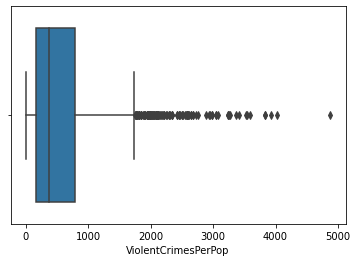

In [69]:
sns.boxplot(data=data, x='ViolentCrimesPerPop')

<AxesSubplot:xlabel='nonViolPerPop'>

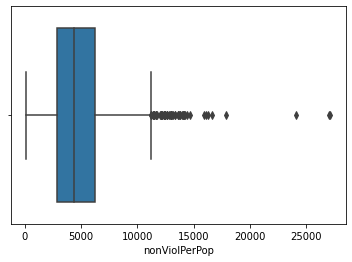

In [71]:
sns.boxplot(data=data, x='nonViolPerPop')

As we can see from both of these plts, we have some data points that are plotted outside of the box plot area and that greatly deviate from the rest of the population. As we're essentially trying to understand what drives violent and non violent crime in communities, these outlier numbers may provide us with insight later on. Nevertheless lets replace the missing values with the median since our data appears to be widely distributed.

In [72]:
nonViol_mean = np.mean(data.nonViolPerPop)
nonViol_median = data.nonViolPerPop.median()

viol_mean = np.mean(data.ViolentCrimesPerPop)
viol_median = data.ViolentCrimesPerPop.median()

print(f"Non Violent Crimes mean: {nonViol_mean}")
print(f"Non Violent Crimes median: {nonViol_median}")
print(f"Violent Crimes mean: {viol_mean}")
print(f"Violent Crimes median: {viol_median}")

Non Violent Crimes mean: 4908.241803588291
Non Violent Crimes median: 4425.450000000001
Violent Crimes mean: 589.0789217652964
Violent Crimes median: 374.06


In [74]:
data.nonViolPerPop.fillna(nonViol_median, inplace=True)
data.ViolentCrimesPerPop.fillna(viol_median, inplace=True)
print(f"Number of missing values in dataset: {data.isnull().sum().sum()}")

Number of missing values in dataset: 0


### Outliers